<a href="https://colab.research.google.com/github/MathBioCU/WSINDy4Weather/blob/main/stratified_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STRATIFIED FORECAST**

In [1]:
import torch
import scipy
import numpy as np
import matplotlib

import torch.linalg as la
from scipy.signal import savgol_filter as SG
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/WSINDy

file_path = '/content/drive/My Drive/WSINDy'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/WSINDy


In [3]:
# Plot settings
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12

matplotlib.rc('xtick', labelsize=9, direction='out')
matplotlib.rc('ytick', labelsize=9, direction='out')

## Forecast Simulation

Imported tensor with shape (62, 62, 100)


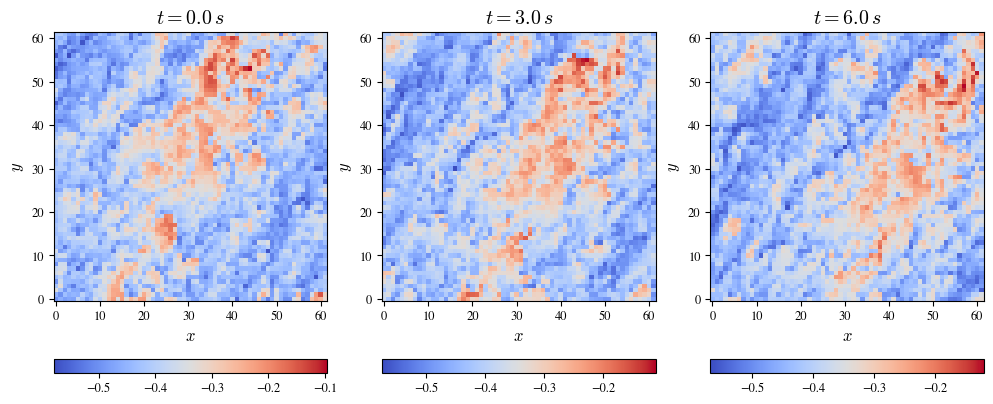

Test data shape (62, 62, 33)


In [4]:
# Read in CSV data
Temp = np.loadtxt(file_path + '/JHTDB/geophysical/temp.csv', delimiter=',')

# Reshape to Nx x ... x Nt tensor
[Lx, Ly, T] = [62, 62, 100*0.075]
[Nx, Ny, Nt] = [62, 62, 100]
[dx, dy, dt] = [1, 1, 0.075]

Temp = torch.tensor(Temp).view(Nx, Ny, -1)
print(f"Imported tensor with shape {Temp.numpy().shape}")

# Space and time
x = torch.arange(0, Nx, dx)
y = torch.arange(0, Ny, dy)
t = torch.arange(0, T, dt)

# Plot
X,Y = torch.meshgrid(x, y, indexing='ij')
fig,ax = plt.subplots(1,3, figsize=(12,5))
for i in range(3):
  thyme = i*40
  im = ax[i].pcolormesh(X, Y, Temp[:,:,thyme].T, cmap='coolwarm')
  plt.colorbar(im, orientation='horizontal')
  ax[i].set_xlabel('$x$')
  ax[i].set_ylabel('$y$')
  ax[i].set_title(f'$t = {0.075 * thyme} \, s$')
plt.show()

# Test data is the last 1/3
use_test_data = True
training = 67
if use_test_data:
  Temp = Temp[:,:,training:]
  t = t[training:]
print(f'Test data shape {Temp.numpy().shape}')

del use_test_data, training
del thyme,fig,ax,i,im

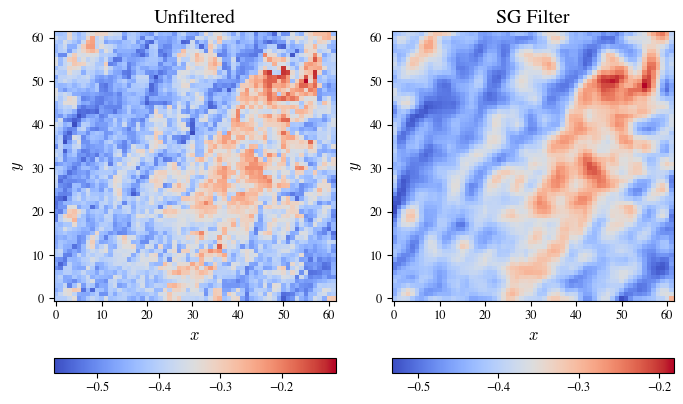

In [5]:
# We'll use a spatial SG filter
U = Temp[:,:,0].clone().numpy()

window = 7
poly = 3

Usg = SG(U, window, poly, deriv=0, delta=dx, axis=0)
Usg = SG(Usg, window, poly, deriv=0, delta=dy, axis=1)

# Plot these guys
fig,ax = plt.subplots(1,2, figsize=(8,5))

im = ax[0].pcolormesh(X, Y, U.T, cmap='coolwarm')
plt.colorbar(im, orientation='horizontal')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
ax[0].set_title(f'Unfiltered')

im = ax[1].pcolormesh(X, Y, Usg.T, cmap='coolwarm')
plt.colorbar(im, orientation='horizontal')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$y$')
ax[1].set_title(f'SG Filter')
plt.show()

del U,Usg,fig,ax,im

The discovered equation was: \begin{align*}
ϑ_{t} = - \alpha_1(ϑ^2)_{x} - \alpha_2(ϑ^2)_{y} - \beta(ϑ)_{y}.
\end{align*}

In [6]:
alpha1 = 2.795720529375978
alpha2 = 2.530315040139922
beta = 3.113882389551759

In [7]:
def SG_deriv(U, window=7, poly=3, axis=0, dx=[1,1], order=1):
  if axis == 0:
    Usg = SG(U.numpy(), window, poly, deriv=order, delta=dx[0], axis=0)
    Usg = SG(Usg, window, poly, axis=1)
  elif axis == 1:
    Usg = SG(U.numpy(), window, poly, axis=0)
    Usg = SG(Usg, window, poly, deriv=order, delta=dx[1], axis=1)
  return torch.from_numpy(Usg)

def RHS(Un, alpha1, alpha2, beta, window=7, poly=3, dx=[1,1]):
  rhs = 0
  rhs += -alpha1 * SG_deriv(Un**2, window=window, poly=poly, axis=0, dx=dx)
  rhs += -alpha2 * SG_deriv(Un**2, window=window, poly=poly, axis=1, dx=dx)
  rhs += -beta * SG_deriv(Un, window=window, poly=poly, axis=1, dx=dx)
  return rhs

def set_BCs(Un, BCs):
  Un[0,:] = BCs[0,:].clone()  # (0,y)
  Un[-1,:] = BCs[-1,:].clone() # (Lx,y)
  Un[:,0] = BCs[:,0].clone()  # (x,0)
  Un[:,-1] = BCs[:,-1].clone() # (x,Ly)
  return

# Solve Un' = f(Un)
def integrate(U0, coeffs, BCs, window=7, poly=3, dx=[1,1], dt=1.):
  [alpha1, alpha2, beta] = coeffs
  Un = U0.clone()

  # RK-4 time-stepping
  Nt = BCs.shape[-1]
  solns = [U0.clone()]
  for n in range(1, Nt):
    K1 = RHS(Un, alpha1, alpha2, beta, window=window, poly=poly, dx=dx)
    K2 = RHS(Un + dt*K1/2, alpha1, alpha2, beta, window=window, poly=poly, dx=dx)
    K3 = RHS(Un + dt*K2/2, alpha1, alpha2, beta, window=window, poly=poly, dx=dx)
    K4 = RHS(Un + dt*K3, alpha1, alpha2, beta, window=window, poly=poly, dx=dx)

    Un += (dt/6)*(K1 + 2*K2 + 2*K3 + K4)
    set_BCs(Un, BCs[:,:,n])
    solns.append(Un.clone())

    if (n % 10) == 0:
      plt.imshow(Un, cmap='coolwarm')
      plt.title(f'Iteration: {n}')
      plt.colorbar()
      plt.show()
  return solns

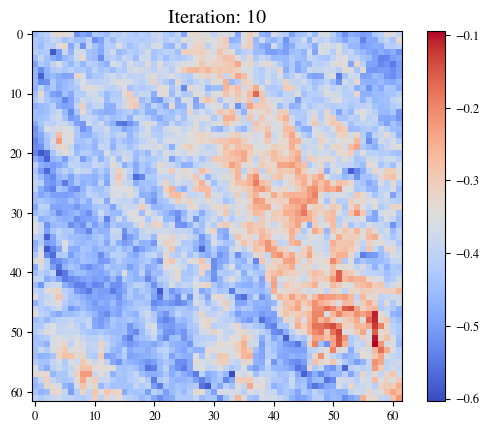

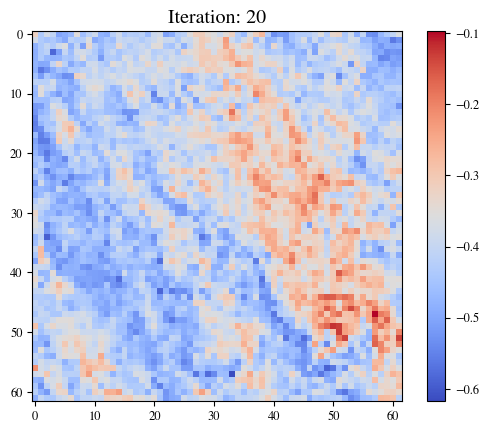

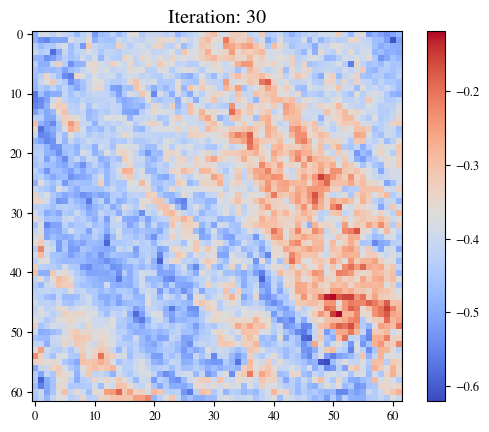

In [8]:
# Initial conditions
Temp0 = Temp[:,:,0]

# Boundary conditions
BCs = Temp.clone()

# Run simulation
coeffs = [alpha1, alpha2, beta]
solns = integrate(Temp0, coeffs, BCs, dx=[dx,dy], dt=dt)

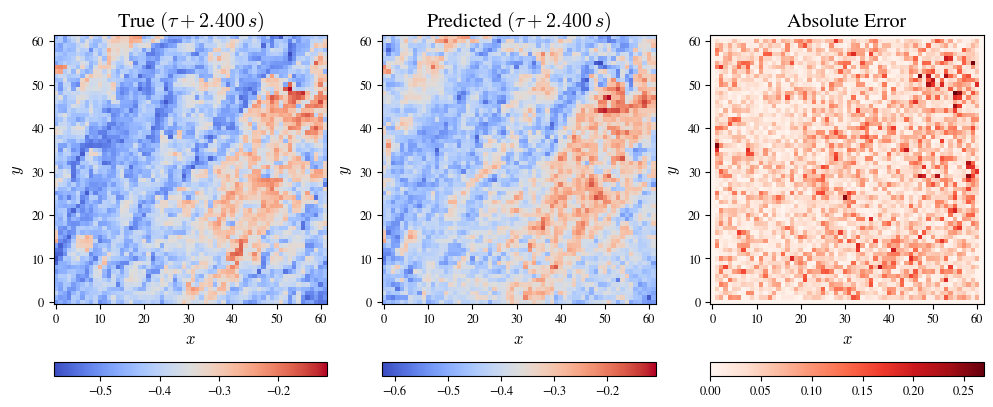

In [9]:
# Compare to true solution
thyme = -1
tau = t[0]
error = abs(Temp[:,:,thyme] - solns[thyme])

fig,ax = plt.subplots(1,3, figsize=(12,5))

im = ax[0].pcolormesh(X, Y, Temp[:,:,thyme].T, cmap='coolwarm')
plt.colorbar(im, orientation='horizontal')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
ax[0].set_title(f'True $(\\tau + {t[thyme]-tau:.3f} \, s)$')

im = ax[1].pcolormesh(X, Y, solns[thyme].T, cmap='coolwarm')
plt.colorbar(im, orientation='horizontal')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$y$')
ax[1].set_title(f'Predicted $(\\tau + {t[thyme]-tau:.3f} \, s)$')

im = ax[2].pcolormesh(X, Y, error.T, cmap='Reds')
plt.colorbar(im, orientation='horizontal')
ax[2].set_xlabel('$x$')
ax[2].set_ylabel('$y$')
ax[2].set_title(f'Absolute Error')
plt.show()

In [10]:
# Save as a csv?
save_csv = False

if save_csv:
  Temp_true = Temp.numpy()
  Temp_learned = torch.stack(solns, dim=-1).numpy()

  True_csv = Temp_true.reshape((62**2, 33))
  Learned_csv = Temp_learned.reshape((62**2, 33))

  # Export as csv
  np.savetxt("ground_truth.csv", True_csv, delimiter=",")
  np.savetxt("prediction.csv", Learned_csv, delimiter=",")
  del True_csv, Learned_csv

## Diagnostics

In [11]:
Temp_true = Temp
Temp_learned = torch.stack(solns, dim=-1)

In [28]:
error = Temp_true - Temp_learned
abs_error = abs(error)

# Time series of average spatial error
Et = abs_error.mean(dim=(0,1))
Et_rel = Et / abs(Temp_true).mean(dim=(0,1))

# Time until tolerance
tau = t - t[0]
t_tol_index = torch.where(Et_rel > 0.1, True, False).nonzero()[0]
t_tol = tau[t_tol_index].item()

# Percentage RMSE
rmse = (la.norm(error)/la.norm(Temp_true)).item()

# Explained variance
top = torch.dot((error).reshape(-1), (error).reshape(-1))
bot = torch.dot((Temp_true-Temp_true.mean()).reshape(-1),
                (Temp_true-Temp_true.mean()).reshape(-1))
var_exp = 1 - (top/bot).item()

# Print some results
print(f'Relative RMSE = {rmse:.3f}')
print(f'Explained var = {var_exp:.3f}')
print(f't_tol = {t_tol:.3f}')
print(f'E_f = {Et_rel[-1].item():.3f}')

Relative RMSE = 0.136
Explained var = 0.465
t_tol = 0.525
E_f = 0.121


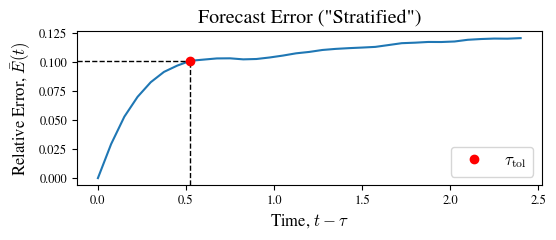

In [37]:
# Plot that time series
fig, ax = plt.subplots(1, figsize=(6,2))

ax.plot(tau, Et_rel)
ax.axvline(x=t_tol, ymin=0, ymax=0.8, ls='--', color='k', lw=1)
ax.axhline(y=Et_rel[t_tol_index], xmin=0, xmax=0.25, ls='--', color='k', lw=1)
ax.plot(t_tol, Et_rel[t_tol_index], 'ro', label='$\\tau_{\\rm{tol}}$')
ax.set_xlabel('Time, $t-\\tau$')
ax.set_ylabel('Relative Error, $\\bar{E}(t)$')
ax.set_title(f'Forecast Error ("Stratified")')
ax.legend()

plt.show()